<a href="https://colab.research.google.com/github/charlottevedrines/Python-Projects/blob/main/Lab4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1cF4Vb-Cnkn5myRA4bHdJI-H9sJGfOXgU/view?usp=sharing

In [1]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [3]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [4]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [5]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [6]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [7]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [8]:
# 1. For each of the columns ["age", "yredu", "capgain", "caploss", "workhr"], report the minimum, maximum, and average value across the dataset.
print("Minimum value in the age column:", subdf["age"].min(), "maximum value:",subdf["age"].max(), "average value:",round(np.average(subdf["age"]),2))
print("Minimum value in the yredu column:", subdf["yredu"].min(), "maximum value:",subdf["yredu"].max(), "average value:",round(np.average(subdf["yredu"]),2))
print("Minimum value in the capgain column:", subdf["capgain"].min(), "maximum value:",subdf["capgain"].max(), "average value:",round(np.average(subdf["capgain"]),2))
print("Minimum value in the caploss column:", subdf["caploss"].min(), "maximum value:",subdf["caploss"].max(), "average value:",round(np.average(subdf["caploss"]),2))
print("Minimum value in the workhr column:", subdf["workhr"].min(), "maximum value:",subdf["workhr"].max(), "average value:",round(np.average(subdf["workhr"]),2))

Minimum value in the age column: 17 maximum value: 90 average value: 38.58
Minimum value in the yredu column: 1 maximum value: 16 average value: 10.08
Minimum value in the capgain column: 0 maximum value: 99999 average value: 1077.65
Minimum value in the caploss column: 0 maximum value: 4356 average value: 87.3
Minimum value in the workhr column: 1 maximum value: 99 average value: 40.44


In [9]:
# Normalize each of the features ["age", "yredu", "capgain", "caploss", "workhr"] so that their values are always between 0 and 1.
for column in ["age", "yredu", "capgain", "caploss", "workhr"]:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [10]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [11]:
df["sex"].unique()

array([' Male', ' Female'], dtype=object)

In [12]:
# Percentage of males on the dataset
percentage_male = sum(df["sex"] == " Male") / len(df["sex"]) *100
print("The percentage of males in the dataset is ", round(percentage_male,3) )

percentage_female = sum(df["sex"] == " Female") / len(df["sex"]) *100
print("The percentage of females in the dataset is ", round(percentage_female,3) )



The percentage of males in the dataset is  66.921
The percentage of females in the dataset is  33.079


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [13]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]
len(df)

32561

In [14]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
print("The number of records contained missing features:", missing.sum())
print("Percentage of records were removed", round(missing.sum()*100 /len(df),3), "%")
df_with_missing = df[missing]
df_not_missing = df[~missing]


The number of records contained missing features: 1843
Percentage of records were removed 5.66 %


In [15]:
df_not_missing

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,0.301370,0.800000,0.021740,0.0,0.397959,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,0.452055,0.800000,0.000000,0.0,0.122449,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,0.287671,0.533333,0.000000,0.0,0.397959,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male
3,0.493151,0.400000,0.000000,0.0,0.397959,Private,Married-civ-spouse,Handlers-cleaners,11th,Husband,Male
4,0.150685,0.800000,0.000000,0.0,0.397959,Private,Married-civ-spouse,Prof-specialty,Bachelors,Wife,Female
...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,Private,Married-civ-spouse,Tech-support,Assoc-acdm,Wife,Female
32557,0.315068,0.533333,0.000000,0.0,0.397959,Private,Married-civ-spouse,Machine-op-inspct,HS-grad,Husband,Male
32558,0.561644,0.533333,0.000000,0.0,0.397959,Private,Widowed,Adm-clerical,HS-grad,Unmarried,Female
32559,0.068493,0.533333,0.000000,0.0,0.193878,Private,Never-married,Adm-clerical,HS-grad,Own-child,Male


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [19]:
df_not_missing["work"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [20]:
data = pd.get_dummies(df_not_missing)

In [22]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [23]:
len(data.columns) # The length of the number of columns is the number of features in the dataset

57

In [24]:
data.columns

Index(['age', 'yredu', 'capgain', 'caploss', 'workhr', 'work_ Federal-gov',
       'work_ Local-gov', 'work_ Private', 'work_ Self-emp-inc',
       'work_ Self-emp-not-inc', 'work_ State-gov', 'work_ Without-pay',
       'marriage_ Divorced', 'marriage_ Married-AF-spouse',
       'marriage_ Married-civ-spouse', 'marriage_ Married-spouse-absent',
       'marriage_ Never-married', 'marriage_ Separated', 'marriage_ Widowed',
       'occupation_ Adm-clerical', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving', 'edu_ 10th',
       'edu_ 11th', 'edu_ 12th', 'edu_ 1st-4th', 'edu_ 5th-6th',
       'edu_ 7th-8th', 'edu_ 9th'

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [25]:
datanp = data.values.astype(np.float32)

In [26]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)
print("cat_index ", cat_index)
print("cat_values", cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    highest_index = np.argmax(onehot)
    return cat_values[feature][highest_index]

cat_index  {'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
cat_values {'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [27]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [28]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [29]:
from torch.utils.data.sampler import SubsetRandomSampler

# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
indices = list(range(len(datanp)))  # Generate indices for the entire dataset
np.random.shuffle(indices)
split_train = int(len(indices) * 0.7)
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

split_test_val = int(len(test_val_indices) * 0.5)
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_set = datanp[train_indices]
val_set = datanp[val_indices]
test_set = datanp[test_indices]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(datanp, batch_size = 64, sampler=train_sampler, num_workers=1)
val_loader = torch.utils.data.DataLoader(datanp, batch_size = 64, sampler=val_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(datanp, batch_size = 64, sampler=test_sampler, num_workers=1)


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [30]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 34), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(34, 25),
            nn.Linear(25, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 25), # TODO -- FILL OUT THE CODE HERE!
            nn.Linear(25, 34),
            nn.Linear(34, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The signmoid activation function outputs values between 0 and 1. This is important here because the goal of our model is to reconstruct a categorical feature that has been one hot encoded and therefore also lies between 0 and 1.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [31]:
import matplotlib.pyplot as plt

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

import matplotlib.pyplot as plt

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_items = 0

        for data in train_loader:
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            train_items += 1

        train_loss[epoch] = total_train_loss / train_items

        model.eval()
        total_val_loss = 0
        val_items = 0

        with torch.no_grad():
            for data in valid_loader:
                datam = zero_out_random_feature(data.clone())
                recon = model(datam)
                loss = criterion(recon, data)
                total_val_loss += loss.item()
                val_items += 1

        val_loss[epoch] = total_val_loss / val_items

        # Calculate accuracy for both training and validation sets
        # The accuracy was calculated after each epoch instead of every few iterations in the interest of
        # run time which was too long otherwise.
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)

        # Print epoch results
        print(f"Epoch: {epoch}, Train Loss: {train_loss[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Train Acc: {train_acc[epoch]:.4f}, Val Acc: {val_acc[epoch]:.4f}")

    epochs = np.arange(1, num_epochs + 1)

    return train_acc, val_acc, train_loss, val_loss, epochs

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [32]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a
 data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0

    for col in catcols:

        for item in data_loader: # minibatches

            inp = item.detach().numpy()

            out = model(zero_out_feature(item.clone(), col)).detach().numpy()

            for i in range(out.shape[0]): # record in minibatch

                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1


    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

Epoch: 0, Train Loss: 0.1703, Val Loss: 0.0759, Train Acc: 0.4408, Val Acc: 0.4378
Epoch: 1, Train Loss: 0.0721, Val Loss: 0.0710, Train Acc: 0.4596, Val Acc: 0.4566
Epoch: 2, Train Loss: 0.0704, Val Loss: 0.0700, Train Acc: 0.4574, Val Acc: 0.4556
Epoch: 3, Train Loss: 0.0676, Val Loss: 0.0629, Train Acc: 0.5002, Val Acc: 0.5010
Epoch: 4, Train Loss: 0.0581, Val Loss: 0.0559, Train Acc: 0.5483, Val Acc: 0.5480
Epoch: 5, Train Loss: 0.0554, Val Loss: 0.0547, Train Acc: 0.5525, Val Acc: 0.5528
Epoch: 6, Train Loss: 0.0544, Val Loss: 0.0541, Train Acc: 0.5567, Val Acc: 0.5552
Epoch: 7, Train Loss: 0.0539, Val Loss: 0.0537, Train Acc: 0.5613, Val Acc: 0.5599
Epoch: 8, Train Loss: 0.0534, Val Loss: 0.0528, Train Acc: 0.5646, Val Acc: 0.5628
Epoch: 9, Train Loss: 0.0525, Val Loss: 0.0520, Train Acc: 0.5710, Val Acc: 0.5688
Epoch: 10, Train Loss: 0.0509, Val Loss: 0.0501, Train Acc: 0.5699, Val Acc: 0.5697
Epoch: 11, Train Loss: 0.0491, Val Loss: 0.0486, Train Acc: 0.5707, Val Acc: 0.5701
Ep

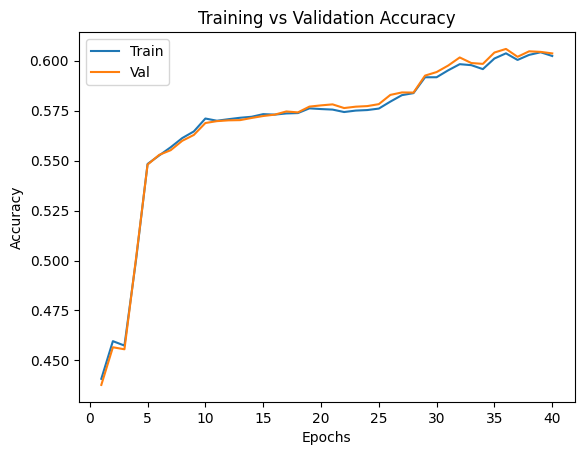

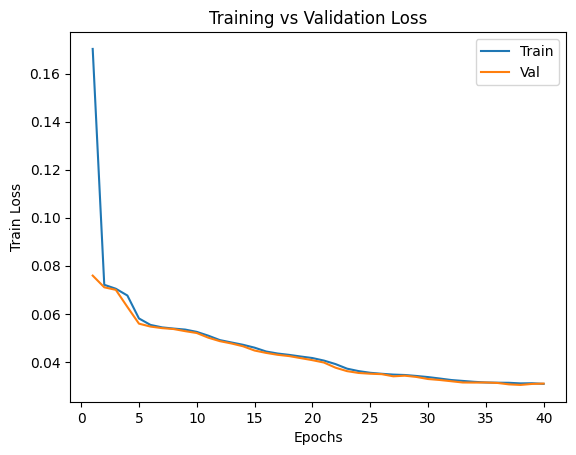

In [53]:
model = AutoEncoder()

train_acc, val_acc, train_loss, val_loss, epochs = train(model, train_loader, val_loader, num_epochs=40, learning_rate=1e-4)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training vs Validation Loss")
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

Epoch: 0, Train Loss: 0.0448, Val Loss: 0.0276, Train Acc: 0.5992, Val Acc: 0.5964
Epoch: 1, Train Loss: 0.0250, Val Loss: 0.0212, Train Acc: 0.5950, Val Acc: 0.5919
Epoch: 2, Train Loss: 0.0215, Val Loss: 0.0206, Train Acc: 0.6009, Val Acc: 0.5969
Epoch: 3, Train Loss: 0.0209, Val Loss: 0.0202, Train Acc: 0.5958, Val Acc: 0.5931
Epoch: 4, Train Loss: 0.0202, Val Loss: 0.0187, Train Acc: 0.6032, Val Acc: 0.6002
Epoch: 5, Train Loss: 0.0187, Val Loss: 0.0183, Train Acc: 0.6048, Val Acc: 0.6022
Epoch: 6, Train Loss: 0.0175, Val Loss: 0.0178, Train Acc: 0.6069, Val Acc: 0.6037
Epoch: 7, Train Loss: 0.0171, Val Loss: 0.0163, Train Acc: 0.5966, Val Acc: 0.5920
Epoch: 8, Train Loss: 0.0167, Val Loss: 0.0160, Train Acc: 0.6100, Val Acc: 0.6080
Epoch: 9, Train Loss: 0.0161, Val Loss: 0.0165, Train Acc: 0.6180, Val Acc: 0.6144
Epoch: 10, Train Loss: 0.0159, Val Loss: 0.0164, Train Acc: 0.6079, Val Acc: 0.6025
Epoch: 11, Train Loss: 0.0169, Val Loss: 0.0170, Train Acc: 0.6054, Val Acc: 0.5999
Ep

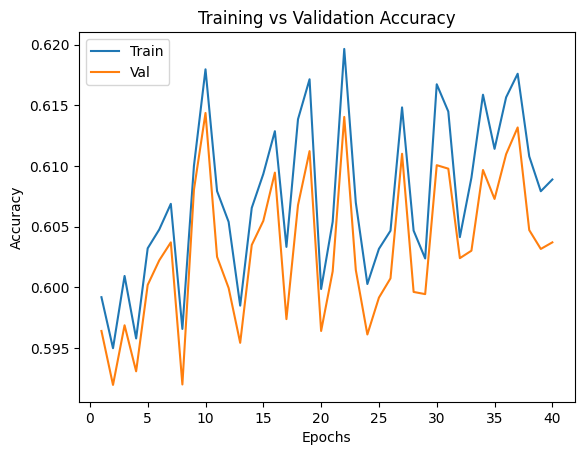

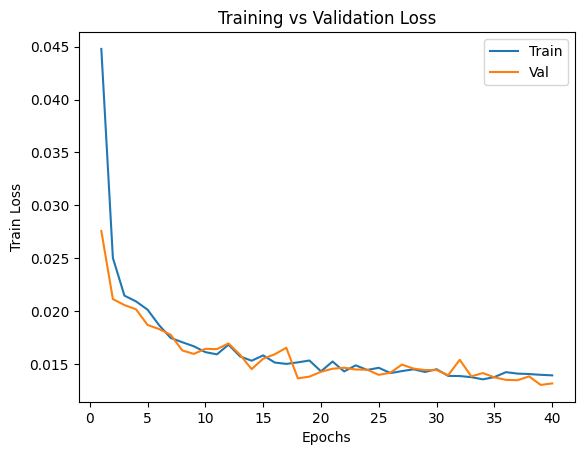

In [54]:
# Changing the learning rate from 0.0001 to 0.01
model1 = AutoEncoder()

train_acc, val_acc, train_loss, val_loss, epochs = train(model1, train_loader, val_loader, num_epochs=40, learning_rate=0.01)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training vs Validation Loss")
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()


In [34]:
# Changing the batch size from 64 to 512

from torch.utils.data.sampler import SubsetRandomSampler

# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
indices = list(range(len(datanp)))
np.random.shuffle(indices)
split_train = int(len(indices) * 0.7)
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

split_test_val = int(len(test_val_indices) * 0.5)
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_set = datanp[train_indices]
val_set = datanp[val_indices]
test_set = datanp[test_indices]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader_512 = torch.utils.data.DataLoader(datanp, batch_size = 512, sampler=train_sampler, num_workers=1)
val_loader_512 = torch.utils.data.DataLoader(datanp, batch_size = 512, sampler=val_sampler, num_workers=1)
test_loader_512 = torch.utils.data.DataLoader(datanp, batch_size = 512, sampler=test_sampler, num_workers=1)

Epoch: 0, Train Loss: 0.0888, Val Loss: 0.0637, Train Acc: 0.5351, Val Acc: 0.5325
Epoch: 1, Train Loss: 0.0577, Val Loss: 0.0513, Train Acc: 0.5626, Val Acc: 0.5628
Epoch: 2, Train Loss: 0.0488, Val Loss: 0.0472, Train Acc: 0.5782, Val Acc: 0.5780
Epoch: 3, Train Loss: 0.0425, Val Loss: 0.0373, Train Acc: 0.5911, Val Acc: 0.5878
Epoch: 4, Train Loss: 0.0362, Val Loss: 0.0356, Train Acc: 0.5930, Val Acc: 0.5888
Epoch: 5, Train Loss: 0.0326, Val Loss: 0.0323, Train Acc: 0.6032, Val Acc: 0.6008
Epoch: 6, Train Loss: 0.0321, Val Loss: 0.0318, Train Acc: 0.6030, Val Acc: 0.6001
Epoch: 7, Train Loss: 0.0304, Val Loss: 0.0292, Train Acc: 0.5983, Val Acc: 0.5964
Epoch: 8, Train Loss: 0.0282, Val Loss: 0.0288, Train Acc: 0.5981, Val Acc: 0.5962
Epoch: 9, Train Loss: 0.0279, Val Loss: 0.0274, Train Acc: 0.6022, Val Acc: 0.6031
Epoch: 10, Train Loss: 0.0261, Val Loss: 0.0252, Train Acc: 0.5932, Val Acc: 0.5889
Epoch: 11, Train Loss: 0.0238, Val Loss: 0.0231, Train Acc: 0.5894, Val Acc: 0.5896
Ep

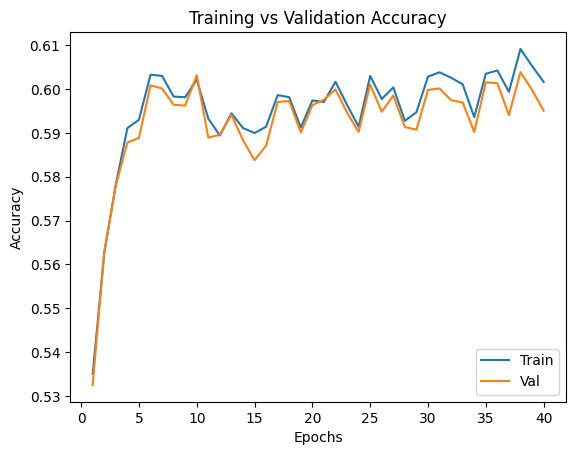

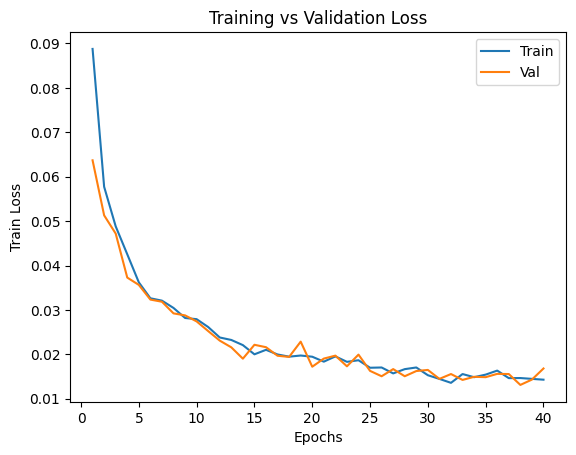

In [37]:
model2 = AutoEncoder()

train_acc, val_acc, train_loss, val_loss, epochs = train(model2, train_loader_512, val_loader_512, num_epochs=40, learning_rate=0.01)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training vs Validation Loss")
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

Epoch: 0, Train Loss: 0.2385, Val Loss: 0.2351, Train Acc: 0.2114, Val Acc: 0.2104
Epoch: 1, Train Loss: 0.2310, Val Loss: 0.2260, Train Acc: 0.2083, Val Acc: 0.2065
Epoch: 2, Train Loss: 0.2193, Val Loss: 0.2108, Train Acc: 0.2030, Val Acc: 0.2033
Epoch: 3, Train Loss: 0.1984, Val Loss: 0.1822, Train Acc: 0.1722, Val Acc: 0.1738
Epoch: 4, Train Loss: 0.1606, Val Loss: 0.1360, Train Acc: 0.3168, Val Acc: 0.3155
Epoch: 5, Train Loss: 0.1151, Val Loss: 0.0974, Train Acc: 0.3775, Val Acc: 0.3766
Epoch: 6, Train Loss: 0.0872, Val Loss: 0.0800, Train Acc: 0.4572, Val Acc: 0.4556
Epoch: 7, Train Loss: 0.0767, Val Loss: 0.0747, Train Acc: 0.4572, Val Acc: 0.4556
Epoch: 8, Train Loss: 0.0737, Val Loss: 0.0730, Train Acc: 0.4572, Val Acc: 0.4556
Epoch: 9, Train Loss: 0.0726, Val Loss: 0.0724, Train Acc: 0.4572, Val Acc: 0.4556
Epoch: 10, Train Loss: 0.0721, Val Loss: 0.0720, Train Acc: 0.4572, Val Acc: 0.4556
Epoch: 11, Train Loss: 0.0718, Val Loss: 0.0718, Train Acc: 0.4608, Val Acc: 0.4578
Ep

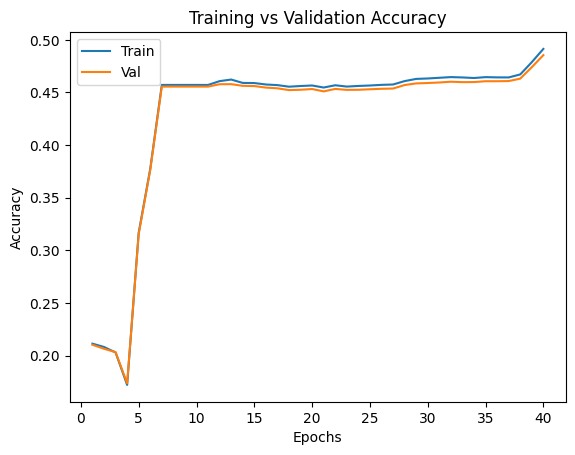

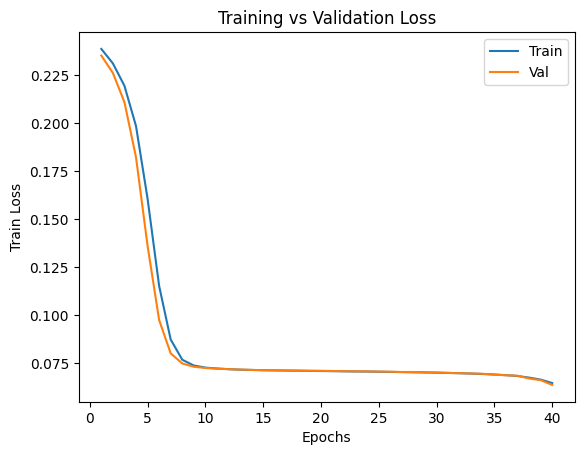

In [35]:
model3 = AutoEncoder()

# Batch size of 512 and a learning rate of 1 e-4
train_acc, val_acc, train_loss, val_loss, epochs = train(model3, train_loader_512, val_loader_512, num_epochs=40, learning_rate=0.0001)

plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Train")
plt.plot(epochs, val_acc, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Training vs Validation Loss")
plt.plot(epochs, train_loss, label="Train")
plt.plot(epochs, val_loss, label="Val")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend(loc='best')
plt.show()

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [38]:
# The chosen model is 'model2' because it has the highest validation accuracy and lowest validation loss
print(get_accuracy(model2, test_loader))

0.5978009259259259


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [16]:
baseline = {}
for col in df_not_missing:
    baseline[col] = df[col].value_counts().idxmax()

In [18]:
baseline_acc = sum(df_not_missing["marriage"] == baseline["marriage"])/len(df_not_missing)
print("The test accuracy of this baseline model for the marriage feature is", round(baseline_acc*100,3), "%")

The test accuracy of this baseline model for the marriage feature is 46.679 %


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The model test accuracy is 0.646 whereas the baseline model test accuracy is 0.477. Because our autoencoder outperforms the baseline, we can conclude that our model is producing significant predictions that are helpful.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [60]:
print("The features of the first person in the test set is: ")
for c in catcols:
  print("Feature:", c ," -> ", get_categorical_value(get_onehot(test_set[0], c),c))

The features of the first person in the test set is: 
Feature: work  ->  Private
Feature: marriage  ->  Divorced
Feature: occupation  ->  Tech-support
Feature: edu  ->  HS-grad
Feature: relationship  ->  Own-child
Feature: sex  ->  Female


Given the that the occupation is tech-support, it is reasonable for a human to guess that this person's highest education level is high school.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [61]:
def zero_out_feature_mod(record, feature):
    """ Set the feature missing in record, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    for i in range(stop_index - start_index):
      record[start_index + i] = 0
    return record

test_input = torch.from_numpy(zero_out_feature_mod(test_set[0], "edu"))

pred = model(test_input)

result = pred.detach().numpy()

for col in catcols:
  print(col + ": " + get_categorical_value(get_onehot(result, col), col))

work: Private
marriage: Never-married
occupation: Other-service
edu: HS-grad
relationship: Unmarried
sex: Female


In [63]:
test_edu = torch.from_numpy(zero_out_feature(test_set[:1], "edu")[0])
prediction = model(test_edu)
get_feature(predict.detach().numpy(), "edu")

'HS-grad'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [62]:
baseline["edu"]

' HS-grad'